# Welcome to Roboflo

Task scheduler for any system with coordinated workers. The original use case is for the Perovskite Automated Spin-Coating Assembly Line (PASCAL) in the Fenning Lab at UC San Diego, where a robotic arm moves small glass slides between stations to perform experiments. 

`roboflo` assumes that you have a set of `Worker`'s that act (independently or in unison) to perform `Task`'s of set duration. Furthermore, one or more `Worker`'s can function to transition between `Task`'s (eg my robot moves a sample from the hotplate to a camera, or my mom moves me from school to soccer practice). These transition moves constitute a special case of `Task`'s , called `Transition`'s. The total set of `Worker`'s and `Transition`'s define your `System`. Sets of `Task`'s are consolidated into `Protocol`'s (eg the same process for five samples or five kids), which are then scheduled (using the `Scheduler` on your `System`) to minimize the total working time. An example schedule is shown below. 

Happy robot-ing!

# Table of Contents

1. Basic Usage (you're in the right place!)
2. [Inserting Protocols into an existing schedule](./insert%20protocols%20into%20current%20schedule.ipynb)
3. [Using Breakpoints](./using%20breakpoints.ipynb)

In [1]:
import roboflo as rf

# Defining the System

First, we need to define our `Worker`'s. A `Worker` is defined by 2-3 variables:

- name (str): an identifier for printing the schedule later.
- capacity (int): how many units the worker can handle at a given time.
- initial_fill (int): optional, the amount units the `Worker` starts with at t=0. This defaults to 0

In [2]:
hotplate = rf.Worker(
    name='hotplate',
    capacity=40,
    one_task_at_a_time=True # we cant run more than one annealing procedure simultaneously, as the temperatures/timings would be different.
)

spincoater = rf.Worker(
    name='spincoater',
    capacity=1
)

storage = rf.Worker(
    name='storage',
    capacity=45,
    # initial_fill=45 #the storage starts full!
)

characterization = rf.Worker(
    name='characterization line',
    capacity=1
)

arm = rf.Worker(
    name='arm',
    capacity=1
)

Next, we define the `Transition`'s by which units can be moved between `Worker`s. These require four arguments:

- duration (int): the time it takes to execute the transition
- source (`Worker`): the worker from which the unit is leaving
- destination (`Worker`): the worker to which the unit is arriving
- workers (list): a list of `Worker`'s which are required to execute this `Transition`

In [3]:
transitions = [
    rf.Transition(
        duration=28,
        source=storage,
        destination=spincoater,
        workers=[arm]
    ),
    rf.Transition(
        duration=20,
        source=spincoater,
        destination=hotplate,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=hotplate,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=storage,
        destination=characterization,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=characterization,
        destination=storage,
        workers=[arm]
    )
]

Together, the `Worker` and `Transition` objects constitute our overall `System`. The arguments here are fairly self explanatory:
- workers (list): a list of `Worker`'s
- transitions (list): a list of `Transition`'s
- starting_worker (list): the default `Worker` at which units originate
- ending_worker(list): the default `Worker` where units go after their last `Task`
- enforce_protocol_order (bool): if `False` (default), protocols may be scheduled out of the order they are generated to reduce total runtime. Tasks within a given protocol will always maintain their order.

In [4]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage,
    enforce_protocol_order=False 
)

# Defining Tasks and Protocols

Robotic systems execute a set of known tasks. These are formalized as `Task` objects, which take four arguments:
- name (str): the name of this task
- workers (list): all `Worker`'s required to execute this task. Note that the _first_ `Worker` in this list is considered the location for `Transition` events.
- duration (int): time it takes to execute this task
- immediate (bool): True/False indicatind whether or not this task must occur immediately after the preceding task.

In [5]:
spincoat = rf.Task(
    name='spincoat',
    workers=[spincoater],
    duration=60,
    immediate=False #we dont have to start right away
)

anneal = rf.Task(
    name='anneal',
    workers=[hotplate],
    duration=60*15,
    # immediate=True, #we want to start annealing right away
    capacity=5,
)
rest = rf.Task(
    name='rest',
    workers=[storage],
    duration=180,
    # immediate=True
)
characterize = rf.Task(
    name='characterize',
    workers=[characterization],
    duration=300,
    immediate=False
)

Often the same set of `Task`'s are applied in a sequence to multiple units/samples. These are formalized as `Protocol`'s, and are generated using the `System` we defined earlier. Basically we pass a name and worklist (list of `Task`'s in order) to define a `Protocol`.

- worklist (list): list of `Task`'s, in order, to be executed on one sample
- name (str): Optional, name of this protocol. names must be unique, and one will be filled in if this parameter is left out.
- min_start (int): Optional, minimum starting time for this protocol. This is useful when adding protocols to a schedule that is already in progress. Defaults to 0

In [6]:
typical_protocol = system.generate_protocol(
    worklist = [
        spincoat, #the tasks we defined above
        anneal,
        rest,
        characterize
    ],
)

In [7]:
typical_protocol.worklist

[<Transition: storage_to_spincoater, runs from nan - nan>,
 <Task: spincoat, runs from nan - nan>,
 <Transition: spincoater_to_hotplate, runs from nan - nan>,
 <Task: anneal, runs from nan - nan>,
 <Transition: hotplate_to_storage, runs from nan - nan>,
 <Task: rest, runs from nan - nan>,
 <Transition: storage_to_characterization line, runs from nan - nan>,
 <Task: characterize, runs from nan - nan>,
 <Transition: characterization line_to_storage, runs from nan - nan>]

A `Protocol` object can be printed to show its contents. Note a few things here:

- The protocol has been given a name "sample{index}"
- While `System.generate_protocol` returns the protocol object, it is stored under the hood - you don't need to keep them in a list, etc.
- the worklist contains `Transition` tasks to move between the `Task`s we put into the initial worklist.
- the runtimes all show as `nan`. This will be solved when generating our schedule later.

In [8]:
for i in range(3):
    system.generate_protocol(
        worklist = [
            spincoat, #the tasks we defined above
            anneal,
            rest,
            characterize
        ],
    )

# Scheduling our Protocols

The `System` contains a `Scheduler` object at `System.scheduler` - we will use this to solve our schedule. Under the hood this uses [Google's ORTools](https://developers.google.com/optimization). We will get the solution status as either OPTIMAL, FEASIBLE, or UNKNOWN - the first two are ok, the latter probably implies that you have a very complicated set of tasks and need to give the solver a longer (potentially unrealistic) time to solve.

arguments:
- solve_time (int): seconds to allow the solver to search for optimal scheduling
- enforce_protocol_order (bool): True/False, whether to force the schedule to process `Protocol`'s in the order you created them.

In [9]:
system.scheduler.solve(
    solve_time=10,
)

Solving final schedule
	solution status: OPTIMAL


### The schedule can be retrieved in three ways:

Visually

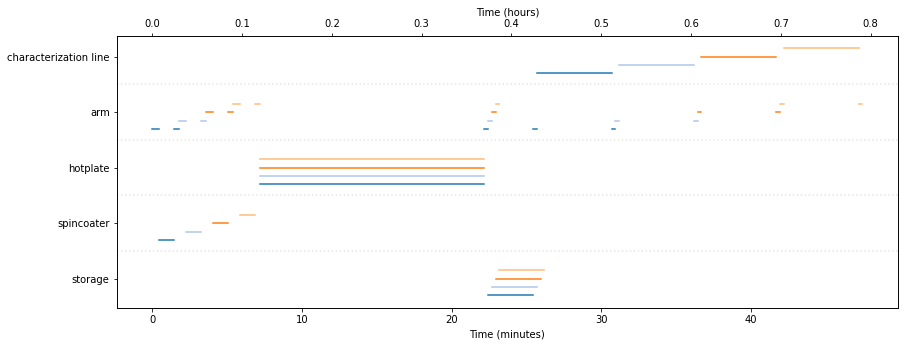

In [10]:
system.scheduler.plot_solution()

In [17]:
for i in range(2):
    system.generate_protocol(
        worklist = [
            spincoat, #the tasks we defined above
            anneal,
            rest,
            characterize
        ],
        min_start = 5*60
    )

In [18]:
system.scheduler.solve(
    solve_time=10,
)

Solving final schedule
	solution status: OPTIMAL


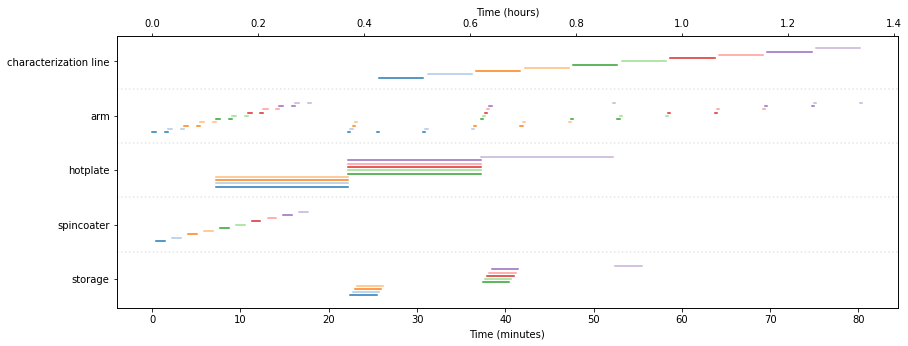

In [19]:
system.scheduler.plot_solution()

As a list of individual tasks, in order

In [11]:
system.scheduler.get_tasklist()

[<Transition: storage_to_spincoater, runs from 0 - 28>,
 <Task: spincoat, runs from 28 - 88>,
 <Transition: spincoater_to_hotplate, runs from 88 - 108>,
 <Transition: storage_to_spincoater, runs from 108 - 136>,
 <Task: spincoat, runs from 136 - 196>,
 <Transition: spincoater_to_hotplate, runs from 196 - 216>,
 <Transition: storage_to_spincoater, runs from 216 - 244>,
 <Task: spincoat, runs from 244 - 304>,
 <Transition: spincoater_to_hotplate, runs from 304 - 324>,
 <Transition: storage_to_spincoater, runs from 324 - 352>,
 <Task: spincoat, runs from 352 - 412>,
 <Transition: spincoater_to_hotplate, runs from 412 - 432>,
 <Transition: storage_to_spincoater, runs from 432 - 460>,
 <Task: spincoat, runs from 460 - 520>,
 <Transition: spincoater_to_hotplate, runs from 520 - 540>,
 <Task: anneal, runs from 540 - 1440>,
 <Transition: storage_to_spincoater, runs from 540 - 568>,
 <Task: spincoat, runs from 568 - 628>,
 <Transition: spincoater_to_hotplate, runs from 628 - 648>,
 <Transition:

As a dictionary, where the tasklist is split into a list per worker. Each list is in order.

In [13]:
tasks_by_worker = system.scheduler.get_tasklist_by_worker()
for worker, tasklist in tasks_by_worker.items():
    print(f'{worker}: {len(tasklist)} tasks, running from {tasklist[0].start}-{tasklist[-1].end}')

<Worker: storage>: 11 tasks, running from 1455-3435
<Worker: spincoater>: 11 tasks, running from 28-1168
<Worker: hotplate>: 3 tasks, running from 540-3240
<Worker: arm>: 55 tasks, running from 0-5265
<Worker: characterization line>: 11 tasks, running from 1650-5250


In each list representation, the start and end times of each `Task` can be accessed to be fed into downstream processes.

In [14]:
tasklist

[<Task: characterize, runs from 1650 - 1950>,
 <Task: characterize, runs from 1980 - 2280>,
 <Task: characterize, runs from 2310 - 2610>,
 <Task: characterize, runs from 2640 - 2940>,
 <Task: characterize, runs from 2970 - 3270>,
 <Task: characterize, runs from 3300 - 3600>,
 <Task: characterize, runs from 3630 - 3930>,
 <Task: characterize, runs from 3960 - 4260>,
 <Task: characterize, runs from 4290 - 4590>,
 <Task: characterize, runs from 4620 - 4920>,
 <Task: characterize, runs from 4950 - 5250>]

In [15]:
first_task = tasklist[0]
first_task

<Task: characterize, runs from 1650 - 1950>

In [16]:
print('this task start at:', first_task.start)
print('this task ends at:', first_task.end)

this task start at: 1650
this task ends at: 1950
